In [3]:
import pandas as pd
from fpl_helpers import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [4]:
# Base path for the CSV files
# Base path for the CSV files
dataframes = [] 
for i in ['2020-21', '2021-22', '2022-23']:
    dataframes.append(get_season_df(i))
data = pd.concat(dataframes, keys=['2020-21', '2021-22', '2022-23'])
data = data.reset_index(level=0).rename(columns={'level_0': 'Season'})

In [5]:
data.columns

Index(['Season', 'name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW', 'id', 'team_a_name', 'team_h_name', 'team_a_difficulty',
       'team_h_difficulty', 'difficulty_difference', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'starts'],
      dtype='object')

## Feature engineering

Create variables for player's
- last score
- average score last 3 matches
- average XP for last 3 matches

In [6]:
features = ['xP', 'assists', 'bonus', 'bps', 'difficulty_difference',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'team_a_score',
       'team_h_score', 'threat', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'starts']

not_features = ['Season', 'name', 'position', 'team', 'kickoff_time', 'total_points', 'large_haul']
for feature in features:
    try:
       data[f'last_{feature}'] = data.groupby('name')[feature].shift(1)
       data[f'last3_{feature}'] = data.groupby('name')[f'last_{feature}'].transform(lambda x: x.rolling(3, 1).mean())
    except Exception as e:
       print(feature)
       print(e)

# Analysing large hauls

In [11]:
data['large_haul'] = data['total_points'] > 14

In [28]:
haul = data[data['total_points'] > 15]
other = data[data['total_points'] <=15]

haul= haul[(haul['position']=='MID') | (haul['position']=='FWD')]
other= other[(other['position']=='MID') | (other['position']=='FWD')]

In [19]:
interesting_factors = [
  'last3_xP',
  'last3_bonus',
  'last3_bps',
  'last3_ict_index',
  'last3_minutes',
  'last3_selected',
  'last3_threat',
  'value',
  'was_home',
  'last3_expected_goal_involvements',
  'difficulty_difference'
]

[Text(6, 0, '0.35'),
 Text(6, 0, '0.59'),
 Text(6, 0, '0.68'),
 Text(6, 0, '0.72'),
 Text(6, 0, '0.73'),
 Text(6, 0, '0.75'),
 Text(6, 0, '0.76'),
 Text(6, 0, '0.81'),
 Text(6, 0, '0.85')]

,Haul (Total points >15),No haul
Xp,5.21,1.41
Bonus,0.54,0.10
Bps,15.60,4.99
Ict index,6.86,1.89
Minutes,70.30,29.03
Selected,1301284.75,200264.50
Threat,28.86,7.02
Value,84.24,54.84
Expected goal involvements,0.23,0.06
Difficulty difference,1.11,-0.05


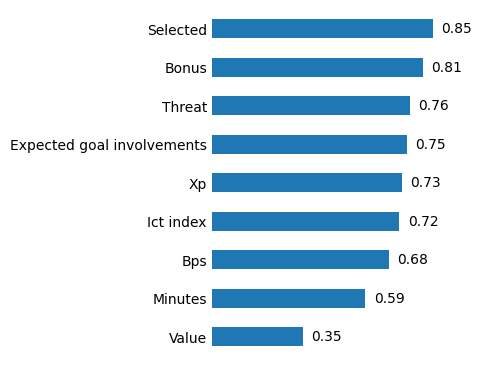

In [98]:
haul_stats = haul[interesting_factors].describe()
other_stats = other[interesting_factors].describe()
relative = (haul_stats.loc['mean'] - other_stats.loc['mean']) / haul_stats.loc['mean']
relative.index = [i.replace("_", " ").replace("last3 ", "").capitalize() for i in relative.index]
ax = relative.sort_values(ascending=True)[:-1].round(2).plot.barh(figsize=(3,4.5))
ax = format_chart(ax)
ax.bar_label(ax.containers[0], padding=6)
ax.tick_params(axis='y', length=0)
ax.get_xaxis().set_visible(False)
table = pd.concat([haul_stats.loc['mean'], other_stats.loc['mean']], axis=1).round(2)
table.columns = ['Haul (Total points >15)', 'No haul']
table.index = [i.replace("_", " ").replace("last3 ", "").capitalize() for i in table.index]
table

In [48]:
haul_stats['difficulty_difference']
other_stats['difficulty_difference']

count    115.000000
mean       1.113043
std        1.219471
min       -2.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: difficulty_difference, dtype: float64

count    41304.000000
mean        -0.053820
std          1.350149
min         -3.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: difficulty_difference, dtype: float64

In [15]:
data = data.dropna(how='any', axis=0)

# Data splitting

Split the data into training and test sets

In [34]:
data_without_na = data.dropna(how='any', axis=0)
X = data_without_na[interesting_factors].dropna(how='any', axis=0)  # Features (drop the target column and any other non-feature columns)
y = data_without_na['total_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model selection and training

In [35]:
# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

LinearRegression()

Mean Squared Error: 4.338180168677761


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

#X = data.drop(not_features + ['large_haul'], axis=1)  # Features (drop the target column and any other non-feature columns)
#y = data_without_na['total_points']>14

y_binary = (data_without_na['total_points'] > 15).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Train the classifier
classifier = RandomForestClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Predict probability
y_prob = classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob)}")

RandomForestClassifier(class_weight='balanced')

Accuracy: 0.9976680917217257
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC-ROC: 0.732770094792884


/usr/local/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
importances = classifier.feature_importances_
feature_names = X_train.columns
sorted_features = sorted(zip(importances, feature_names), reverse=True)
sorted_features


[(0.140938129030599, 'last3_selected'),
 (0.13796668342336604, 'last3_xP'),
 (0.13167324953256682, 'last3_ict_index'),
 (0.12363533440917227, 'last3_threat'),
 (0.11275885380265538, 'last3_bps'),
 (0.08413093906450139, 'value'),
 (0.0754241084292866, 'last3_expected_goal_involvements'),
 (0.07247850780572684, 'last3_minutes'),
 (0.05018156874730393, 'difficulty_difference'),
 (0.04964850659601468, 'last3_bonus'),
 (0.021164119158807147, 'was_home')]

403      1014.0
573      5871.0
574      9491.0
575    124903.0
576     40132.0
Name: last_selected, dtype: float64